## 0. Import relevant libraries

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import random as rd
import pickle

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, BSpline, CubicSpline, PchipInterpolator
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from csaps import csaps

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## 1. Import features data

In [2]:
" Import data as Python pandas DataFrame "

_ADSORBATE_ = 'CH4'

LOC_STR = "/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/complete_data_avail.xlsx"
_DATA_ = pd.read_excel(LOC_STR, sheet_name=0, header=0, index_col='name')
            
_DATA = _DATA_[['density', 'spg', 'volume', 'pld', 'lcd', 'void_frac', 'surf_area_m2g',
       'surf_area_m2cm3', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere',
       'largest_included_sphere', 'largest_included_sphere_free']]


## 2. Import output variables' data

In [3]:
ADSORBATE_LOC_STR = "/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/"+ _ADSORBATE_ + ".xlsx"

ADSORBATE_xl = pd.ExcelFile(ADSORBATE_LOC_STR)
len(ADSORBATE_xl.sheet_names)  # sheet names


197

## 3. Obtain common adsorbents

In [4]:
_COMMON_ADSORBENTS = list(set(ADSORBATE_xl.sheet_names).intersection(_DATA.index))
print('There are ' + str(len(_COMMON_ADSORBENTS)) + ' common adsorbents.')


There are 190 common adsorbents.


### 3.1 Reindex based on common adsorbents

In [5]:
_DATA_REINDEXED = _DATA.reindex(_COMMON_ADSORBENTS)

print('Shape of the inputs is: ', _DATA_REINDEXED.shape)


Shape of the inputs is:  (190, 16)


## Load the data

Will only need to run this step in the future

In [6]:
with open('CH4_TRAIN.npy', 'rb') as TRAIN_FILE:
    TRAIN_ADSORBENTS = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    
with open('CH4_TEST.npy', 'rb') as TEST_FILE:
    TEST_ADSORBENTS = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    

## Evaluate Results – 323 K

In [8]:
with open('CH4_RESULTS_323.npy', 'rb') as RESULTS_FILE:
    
    X_train = np.load(RESULTS_FILE, allow_pickle=True)
    X_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred = np.load(RESULTS_FILE, allow_pickle=True)
    y_train = np.load(RESULTS_FILE, allow_pickle=True)
    y_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_train = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_test = np.load(RESULTS_FILE, allow_pickle=True)
    P_TRAIN_STD = np.load(RESULTS_FILE, allow_pickle=True)


In [9]:
def predict_for_zeolite_323(_P_, normalized_features):
    
    P = _P_/P_TRAIN_STD
    
    density = normalized_features[0]; spg = normalized_features[1]; volume = normalized_features[2];
    pld = normalized_features[3]; lcd = normalized_features[4]; void_frac = normalized_features[5];
    surf_area_m2g = normalized_features[6]; surf_area_m2cm3 = normalized_features[7];
    ASA = normalized_features[8]; AV = normalized_features[9]; NASA = normalized_features[10];
    NAV = normalized_features[11]; VolFrac = normalized_features[12];
    largest_free_sphere = normalized_features[13]; largest_included_sphere = normalized_features[14]
    largest_included_sphere_free = normalized_features[15]
    
    f1 = ((((largest_included_sphere)*np.exp(NAV)*np.exp(-surf_area_m2cm3)) * P / (1 + ((largest_included_sphere)*np.exp(NAV)*np.exp(-surf_area_m2cm3)) * P)) - 0.07469040214406462)/0.23351307544167757; beta1 = -0.4054507842872319
    f2 = (((1*np.exp(VolFrac)/np.exp(-AV)) * P / (1 + (1*np.exp(VolFrac)/np.exp(-AV)) * P)) - 0.593439038924528)/0.19855903035643785; beta2 = -3.5824569383000946
    f3 = (((1*np.exp(void_frac)/1) * P / (1 + (1*np.exp(void_frac)/1) * P)) - 0.6258918477237851)/0.19909573031440259; beta3 = 3.9932667095050705
    f4 = ((((AV)/np.exp(VolFrac)*(void_frac)) * P / (1 + ((AV)/np.exp(VolFrac)*(void_frac)) * P)) - 0.026347531768028034)/0.033050115887121194; beta4 = 0.5222507180877926
    f5 = (((np.exp(-NASA)*((surf_area_m2cm3)**2)*(spg)) * P / (1 + (np.exp(-NASA)*((surf_area_m2cm3)**2)*(spg)) * P)) - 0.451590663829706)/0.4976497103725683; beta5 = 0.004795464592376811
    f6 = (((((surf_area_m2cm3)**2)*np.exp(-volume)*(volume)) * P / (1 + (((surf_area_m2cm3)**2)*np.exp(-volume)*(volume)) * P)) - 0.04040880811128878)/0.05992104058313283; beta6 = -0.1129628499436825
    f7 = (((1/np.exp(surf_area_m2g)/(pld)) * P / (1 + (1/np.exp(surf_area_m2g)/(pld)) * P)) - 0.033471221601783376)/0.11285951143033723; beta7 = 0.013835556053187287
    f8 = (((((VolFrac)**2)/np.exp(-pld)/1) * P / (1 + (((VolFrac)**2)/np.exp(-pld)/1) * P)) - 0.3805783317820693)/0.36837799819503636; beta8 = -0.09608874134668977
    intercept = 0
    theta = beta1*f1 + beta2*f2 + beta3*f3 + beta4*f4 + beta5*f5 + beta6*f6 + beta7*f7 + beta8*f8
    loading_at_zero_P = -beta1*0.07469040214406462/0.233513075441677571 + -beta2*0.593439038924528/0.198559030356437852 + -beta3*0.6258918477237851/0.199095730314402593 + -beta4*0.026347531768028034/0.0330501158871211944 + -beta5*0.451590663829706/0.49764971037256835 + -beta6*0.04040880811128878/0.059921040583132836 + -beta7*0.033471221601783376/0.112859511430337237 + -beta8*0.3805783317820693/0.368377998195036368
    epsilon_max = 1
    d = np.abs(P - 0)
    alpha = 2
    yt = theta + intercept + np.mean(y_train) + np.abs(loading_at_zero_P + np.mean(y_train))* epsilon_max * np.exp(-alpha * d)
    
    return yt


# Specific Adsorbent

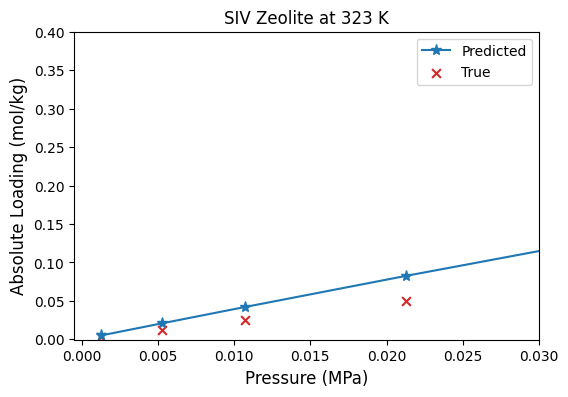

In [16]:
_specific_adsorbent_ = 'SIV'
plt.figure(figsize=(6,4), dpi=100)

CO2_OG_LOC_STR = r"/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/" + _ADSORBATE_ + ".xlsx"
CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_specific_adsorbent_)

_specific_pressures_ = np.array([p for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                'Temperature (K)']==323]['Pressure (Pa)']])
predictions = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_specific_adsorbent_])) for p in _specific_pressures_]

plt.plot(_specific_pressures_/1e6, predictions, label='Predicted', c='tab:blue', marker='*', markersize=8)

plt.scatter(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']/1e6,
           CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Absolute Loading (mol/kg)'],
                   c='tab:red', label='True', marker='x', s=40)

plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
plt.xlabel('Pressure (MPa)', fontsize=12)

plt.title(r'{:s} Zeolite at 323 K'.format(_specific_adsorbent_))

plt.ylim(-0.0005, 0.4)
plt.xlim(-0.0005, 0.03)
plt.legend()
plt.show()


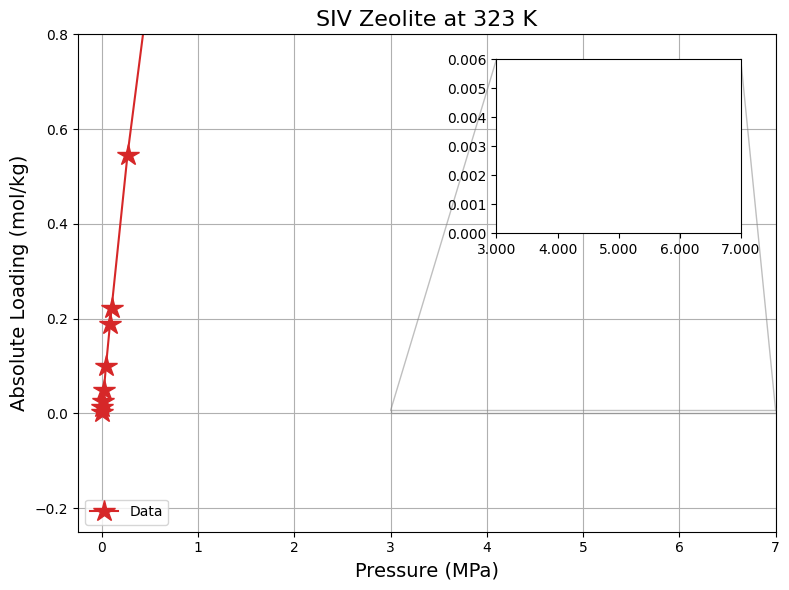

In [17]:
x = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']/1e6
y = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Absolute Loading (mol/kg)']

# Assuming x and y are your numpy arrays
# Create main figure and plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, label='Data', c='tab:red', marker='*', markersize=16)
ax.set_xlabel('Pressure (MPa)', fontsize=14)
ax.set_ylabel('Absolute Loading (mol/kg)', fontsize=14)
ax.set_title(r'{:s} Zeolite at 323 K'.format(_specific_adsorbent_), fontsize=16)
ax.set_xlim(-0.25, 7)  # Set main plot x range
ax.set_ylim(-0.25, 0.8)
ax.grid(True)

# Create inset axes
axins = ax.inset_axes([0.6, 0.6, 0.35, 0.35])

# Plot zoomed region
axins.plot(x, y, label='Data', c='tab:red', marker='*', markersize=12)
axins.set_xlim(3, 7)  # Zoom in to very small x range
# Get y values in the zoomed region
mask = (x >= 3.2) & (x <= 6.6)
y_zoom = y[mask]
axins.set_ylim(0,0.006)
# axins.set_ylim(min(y_zoom) - 0.1, max(y_zoom) + 0.1)
axins.grid(False)

# Add small tick marks for the zoomed region
axins.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Draw box showing zoom area
ax.indicate_inset_zoom(axins)

plt.legend()
plt.tight_layout()
plt.show()

RUT Input contains NaN.


/var/folders/s6/wmy07hwx6j5fzckbkn3pv9540000gn/T/ipykernel_53569/1935639153.py:19: RuntimeWarning: overflow encountered in exp
  f7 = (((1/np.exp(surf_area_m2g)/(pld)) * P / (1 + (1/np.exp(surf_area_m2g)/(pld)) * P)) - 0.033471221601783376)/0.11285951143033723; beta7 = 0.013835556053187287
/var/folders/s6/wmy07hwx6j5fzckbkn3pv9540000gn/T/ipykernel_53569/1935639153.py:19: RuntimeWarning: overflow encountered in exp
  f7 = (((1/np.exp(surf_area_m2g)/(pld)) * P / (1 + (1/np.exp(surf_area_m2g)/(pld)) * P)) - 0.033471221601783376)/0.11285951143033723; beta7 = 0.013835556053187287
/var/folders/s6/wmy07hwx6j5fzckbkn3pv9540000gn/T/ipykernel_53569/2490978071.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6

MAR Input contains NaN.


/var/folders/s6/wmy07hwx6j5fzckbkn3pv9540000gn/T/ipykernel_53569/1935639153.py:19: RuntimeWarning: overflow encountered in exp
  f7 = (((1/np.exp(surf_area_m2g)/(pld)) * P / (1 + (1/np.exp(surf_area_m2g)/(pld)) * P)) - 0.033471221601783376)/0.11285951143033723; beta7 = 0.013835556053187287


CHA Input contains NaN.


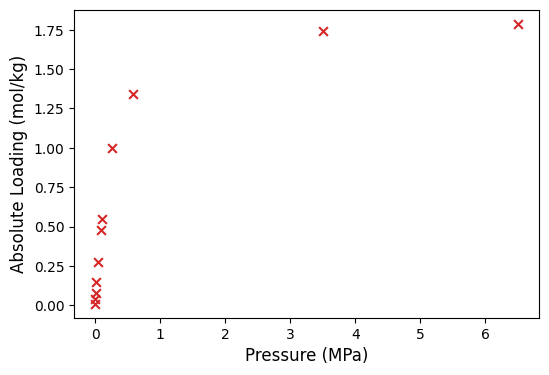

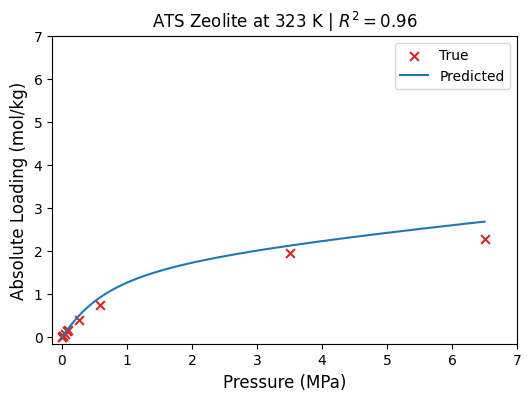

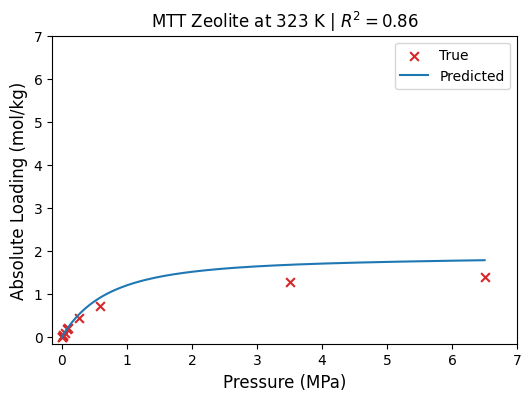

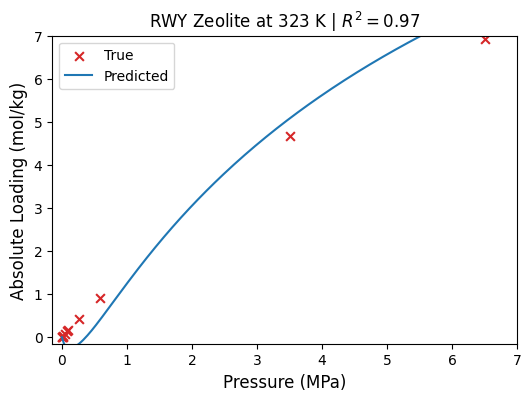

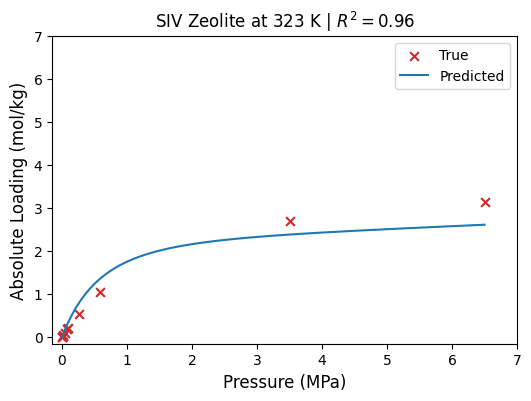

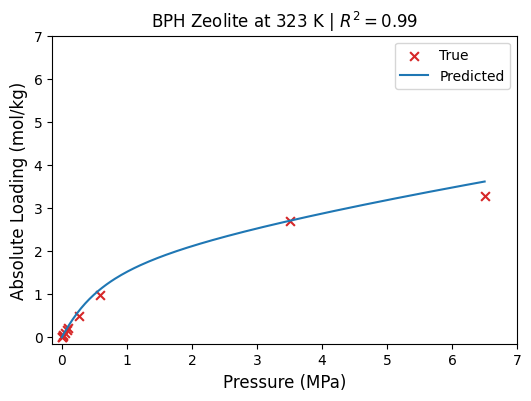

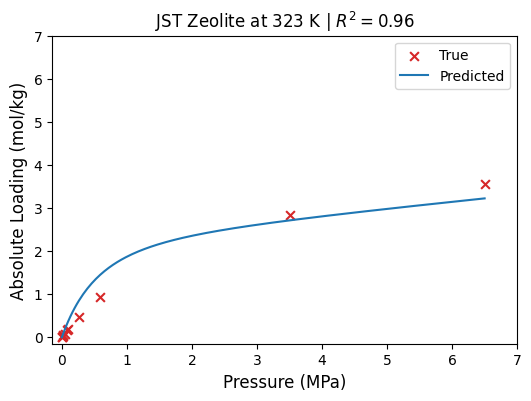

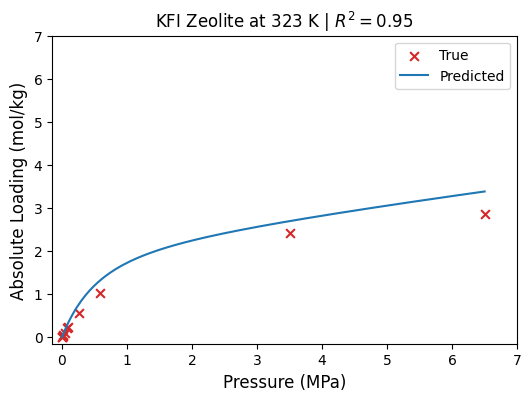

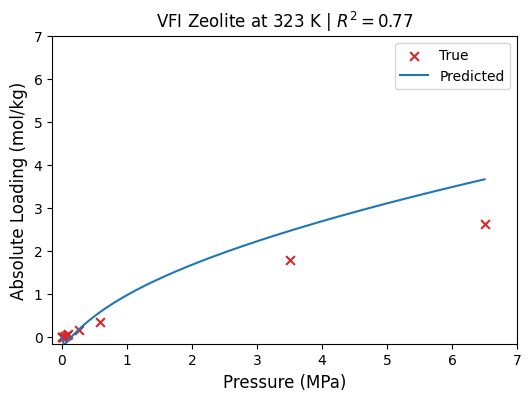

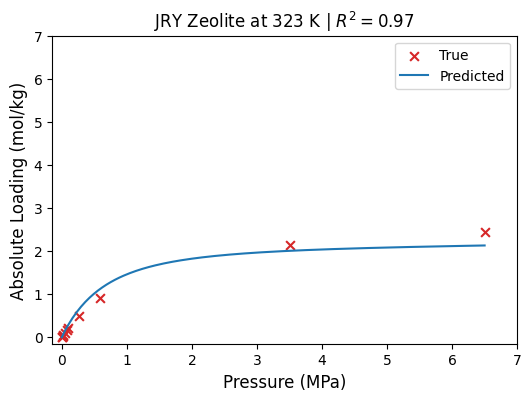

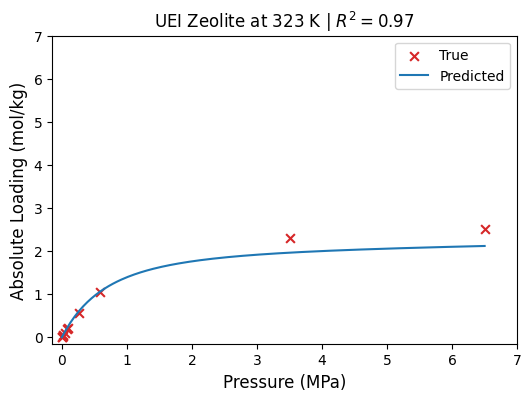

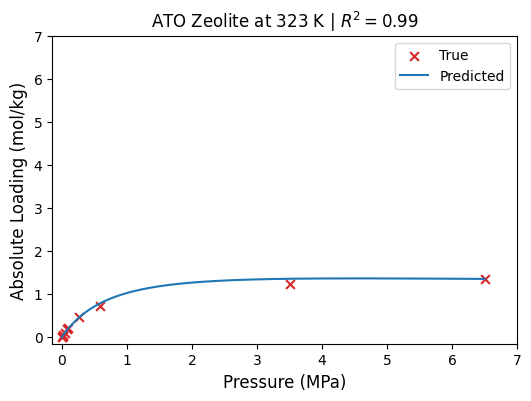

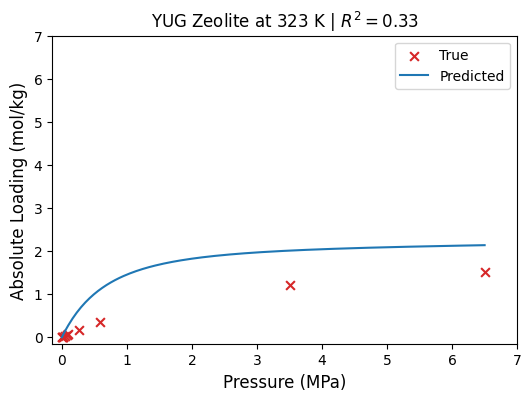

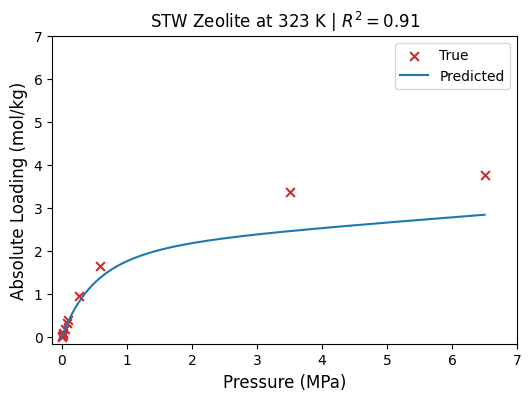

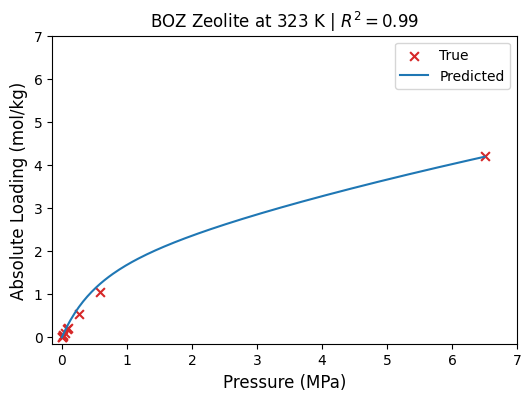

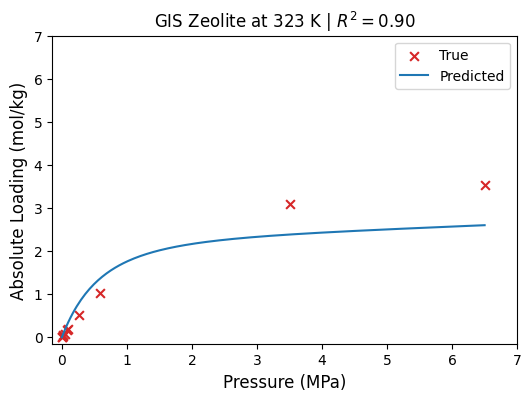

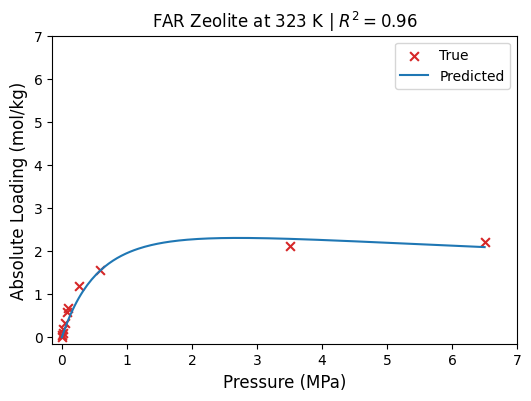

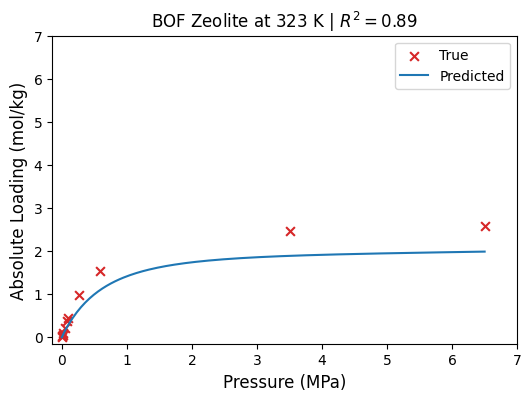

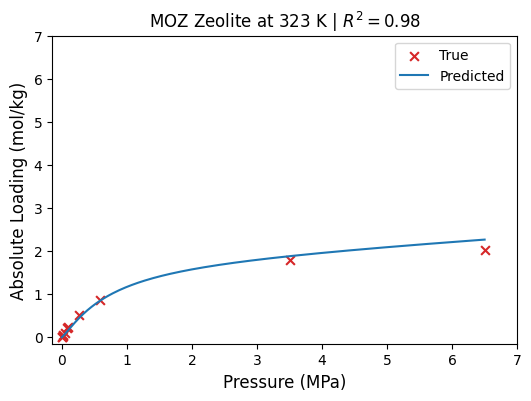

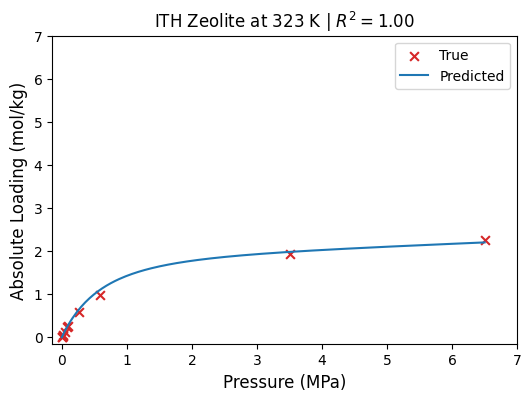

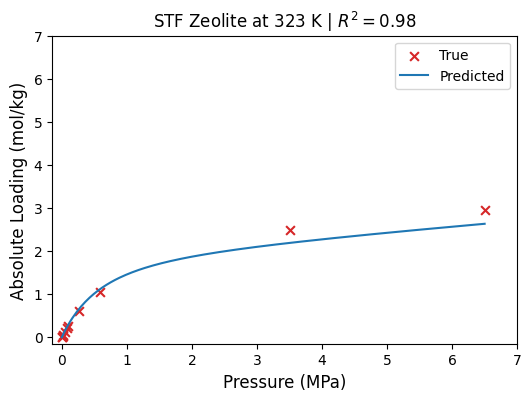

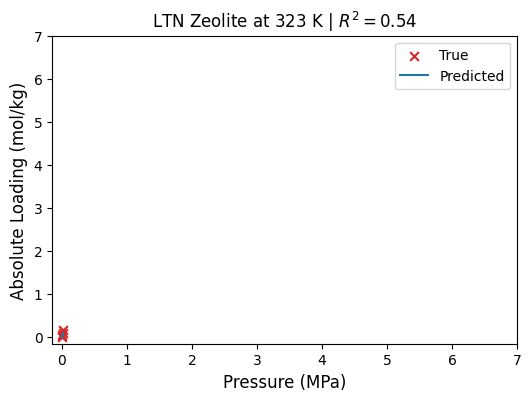

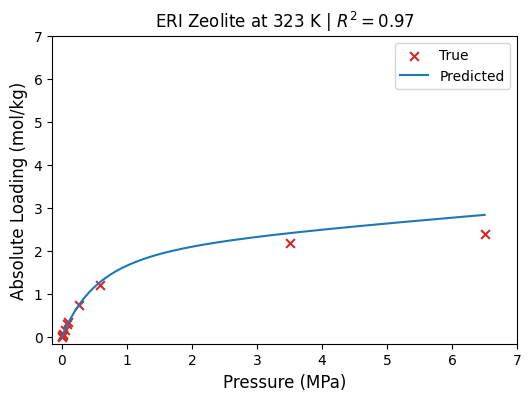

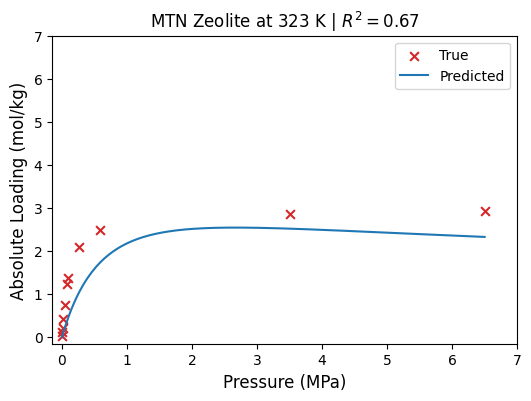

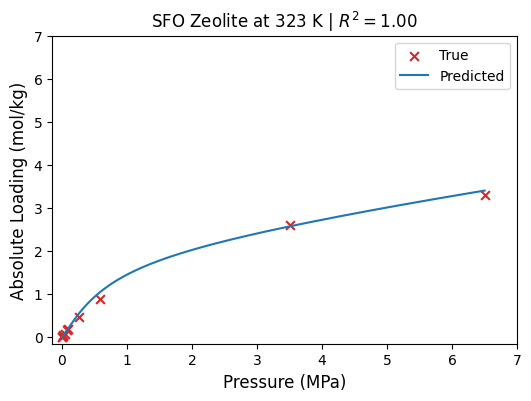

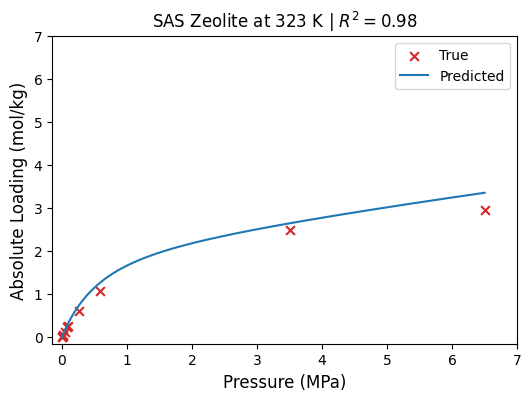

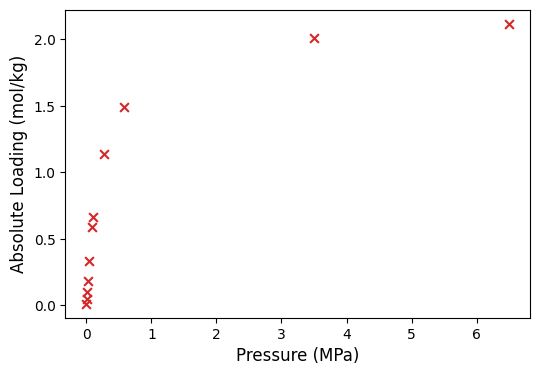

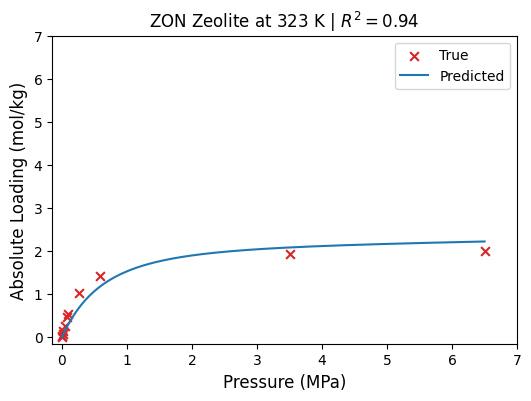

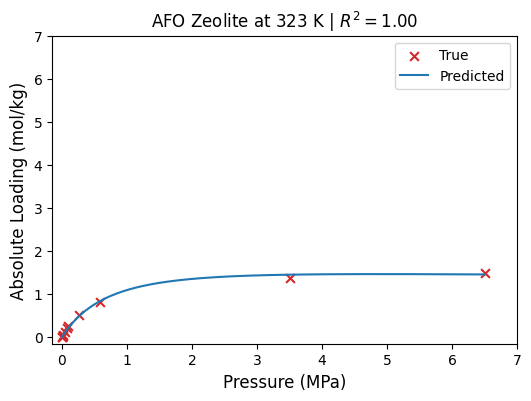

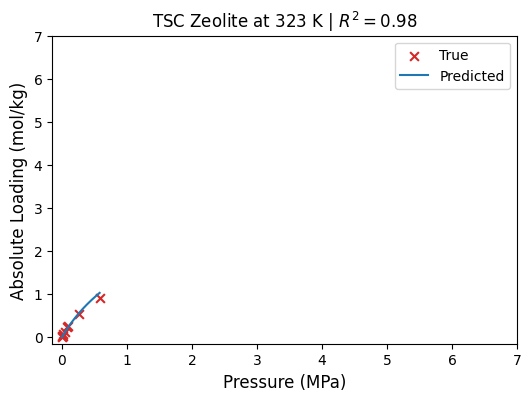

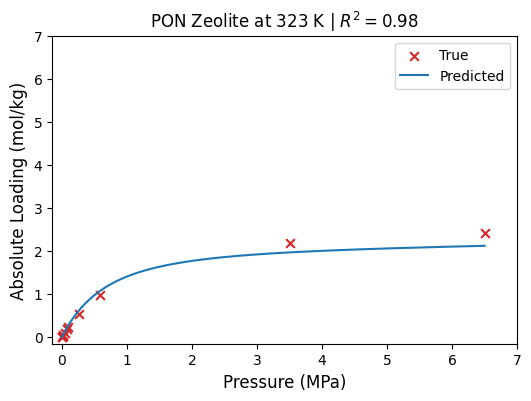

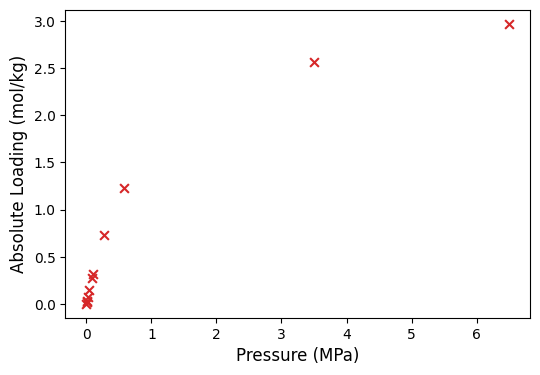

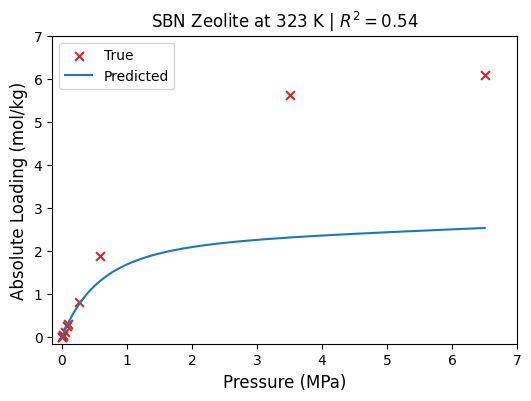

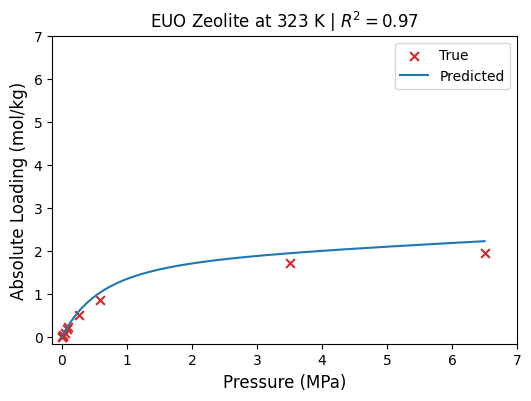

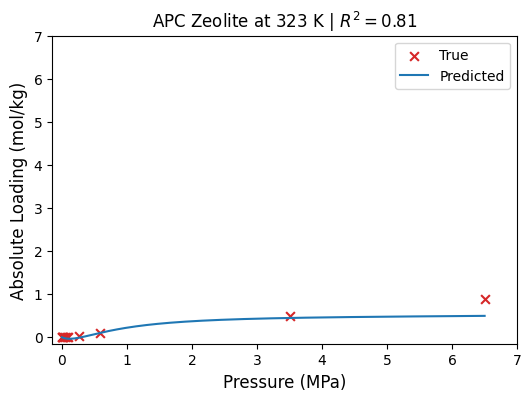

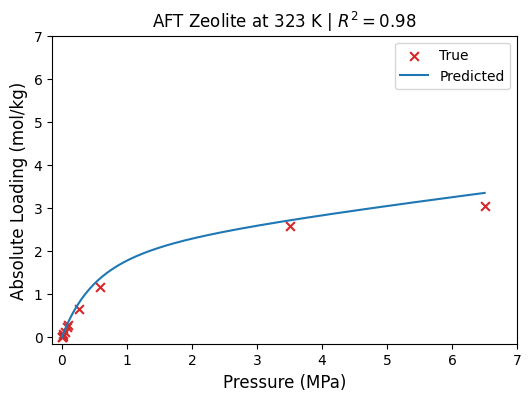

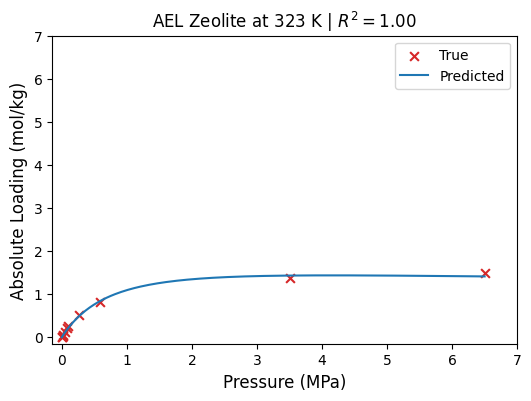

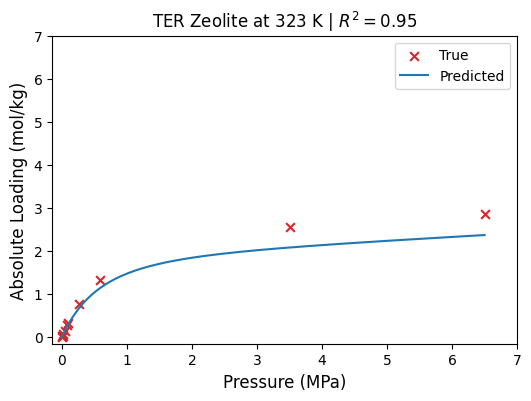

In [13]:
_323_real_ = []
_323_pred_ = []

for _test_z_ in TEST_ADSORBENTS:
# for _test_z_ in TRAIN_ADSORBENTS:
    
    try:
        plt.figure(figsize=(6,4), dpi=100)

        CO2_OG_LOC_STR = r"/Users/arijitchakraborty/Library/CloudStorage/GoogleDrive-ac4758@columbia.edu/My Drive/Research/7_Zeolite_wTAMU_CES/Data/" + _ADSORBATE_ + ".xlsx"
        CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_test_z_)
        
        _specific_pressures_ = np.array([p for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                        'Temperature (K)']==323]['Pressure (Pa)']])
        _specific_predictions_ = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in _specific_pressures_]

        plt.scatter(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']/1e6,
                   CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Absolute Loading (mol/kg)'],
                           c='tab:red', label='True', marker='x', s=40)

        min_p = min(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)'])
        max_p = max(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)'])
        p_range = np.linspace(0, max_p, 200)
        predictions = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in p_range]

        plt.plot(p_range/1e6, predictions, label='Predicted', c='tab:blue')
        
        plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
        plt.xlabel('Pressure (MPa)', fontsize=12)
        
        plt.title(r'{:s} Zeolite at 323 K | $R^{:d}={:.2f}$'.format(_test_z_,2, r2_score(
                    CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323][
                        'Absolute Loading (mol/kg)'], [predict_for_zeolite_323(p, list(
                            _DATA_REINDEXED.loc[_test_z_])) for p in CO2_temp_adsorbent_data[
                                CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']])))
        
        _a_ = CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]
        _323_pred_.append(_specific_predictions_)
        _323_real_.append(_a_['Absolute Loading (mol/kg)'].tolist())
    
        plt.ylim(-0.15,7)
        plt.xlim(-0.15, 7)
        plt.legend()
    except Exception as e:
        print(_test_z_, e)


In [14]:
def flatten_concatenation(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

_preds = np.array(flatten_concatenation(_323_pred_))
_real = np.array(flatten_concatenation(_323_real_))

_323_preds = np.array(flatten_concatenation(_323_pred_))
_323_real = np.array(flatten_concatenation(_323_real_))

new_test_real = np.delete(_323_real, np.argwhere(np.isnan(_323_real)))
new_test_preds = np.delete(_323_preds, np.argwhere(np.isnan(_323_real)))
new_new_test_real = np.delete(new_test_real, np.argwhere(np.isnan(new_test_preds)))
new_new_test_preds = np.delete(new_test_preds, np.argwhere(np.isnan(new_test_preds)))

print(r2_score(new_new_test_real, new_new_test_preds))
print(mean_absolute_error(new_new_test_real, new_new_test_preds))


0.8926556270990593
0.14620123901148968
